In [1]:
from src.freecond import FreeCondPipeline
from src.free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d
import torch

device = "cuda"
torch.cuda.set_device(0)
"""
pipe = FreeCondPipeline.from_pretrained(
    'Lykon/dreamshaper-8-inpainting',
    variant="fp16",
    torch_dtype=torch.float16,
).to(device)
"""

pipe = FreeCondPipeline.from_pretrained(
 "sd-legacy/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
).to(device)

"""
pipe = FreeCondPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)
"""

/home/bluedyee/anaconda3/envs/hdpainter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
safety_checker/model.safetensors not found
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/bluedyee/anaconda3/envs/hdpainter/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage direc

'\npipe = FreeCondPipeline.from_pretrained(\n    "stabilityai/stable-diffusion-2-inpainting",\n    torch_dtype=torch.float16,\n).to(device)\n'

In [2]:
from PIL import ImageFont
from PIL import ImageDraw 

def add_font(image, text="hi", font_size=20, position=(0,0), color=(0,255,0)):
    # Step 2: Create an ImageDraw object to draw on the image
    image=image.convert("RGB")
    draw = ImageDraw.Draw(image)
    # Optional: Load a custom font (e.g., TrueType font) if you want a specific font
    # font = ImageFont.truetype("arial.ttf", size=40)  # Ensure the .ttf file is available
    # Load a custom font with the specified font size
    try:
        # Ensure the .ttf file is available in your system or provide the full path
        font = ImageFont.truetype("Arial.ttf", font_size)
    except IOError:
        # If the custom font is not found, fall back to the default font
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    # Step 4: Write text on the image
    draw.text(position, text, fill=color, font=font)
    return image


# Vis with prompt control

Activating VIS Attention Control...
# Visualize cross attention (1, 3, 5, 7... layers) = True
# Visualize self attention (0, 2, 4, 6 ... layers)= False


100%|██████████| 50/50 [00:07<00:00,  6.27it/s]


Activating VIS Attention Control...
# Visualize cross attention (1, 3, 5, 7... layers) = True
# Visualize self attention (0, 2, 4, 6 ... layers)= False
Bi frequency rescale
re write to u_forward_custom
shifting the mean, variance of initial noise latent


  0%|          | 0/50 [00:00<?, ?it/s]/home/bluedyee/github_repo/INPAINTING/FreeCond_schedule/src/freq.py:83: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:31.)
  x_freq = fft.fftn(x, dim=(-2, -1))
100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


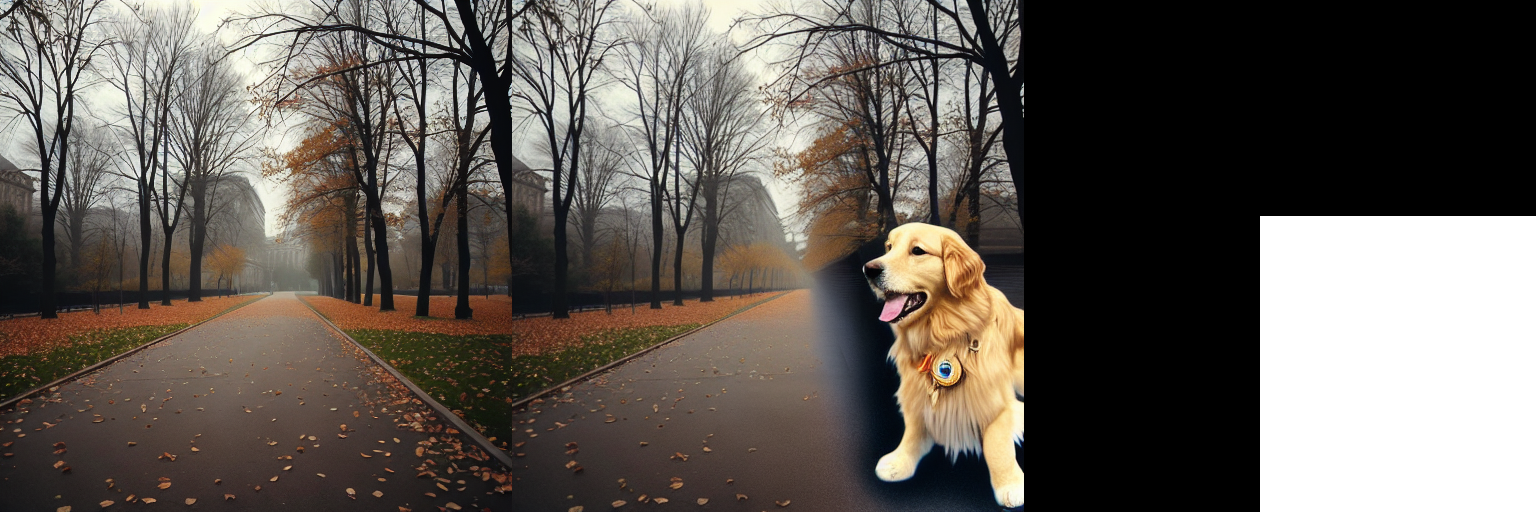

In [3]:
from PIL import Image
import pandas as pd
import os
from diffusers import DDIMScheduler
from diffusers.utils import load_image, make_image_grid
from src.free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d

from src.vis_attn_control import VISAttentionControl, regiter_attention_editor_diffusers
pipe.scheduler=DDIMScheduler.from_config(pipe.scheduler.config)

###
fgmask_1=1
fgmask_2=1
bgmask_1=0
bgmask_2=0

###
idx=14
nprompt="word, bad quality, bad anatomy, ugly, mutation, blurry, error"
SEED=777
data_dir="FCinpaint_bench"
df=pd.read_csv("FCinpaint_bench/FCinpaint_bench_info.csv", index_col=None)
for index, data in df[idx:idx+1].iterrows():
    prompt=data["prompt"]
    image_path=os.path.join(data_dir,data["image"])
    #image_path="masks/gray_mask.png"
    mask_path=os.path.join(data_dir,data["mask"])
    mask_path="masks/black_mask.png"
    init_image=Image.open(image_path).resize((512,512)).convert("RGB")
    mask=Image.open(mask_path).resize((512,512))
    condition_mask, c_masked_image_latents = pipe.prepare_mask_condition(init_image,mask)
    torch.manual_seed(SEED)
    n_editor = VISAttentionControl(start_step=0,end_step=50, start_layer=0, end_layer=16, vis_self=False, vis_cross=True,vis_cross_token=True)
    regiter_attention_editor_diffusers(pipe, n_editor)
    out_normal=pipe.normal_forward(prompt, init_image, condition_mask, c_masked_image_latents,
                                    guidance_scale=15, negative_prompt=nprompt, scheduler_step="ddim",demo=False)
    

    #mask_path=os.path.join(data_dir,data["mask"])
    mask_path="masks/right_bot_mask.png"
    init_image=Image.open(image_path).resize((512,512)).convert("RGB")
    mask=Image.open(mask_path).resize((512,512))
    condition_mask, c_masked_image_latents = pipe.prepare_mask_condition(init_image,mask)
    editor = VISAttentionControl(start_step=0,end_step=50, start_layer=0, end_layer=16, vis_self=False, vis_cross=True,vis_cross_token=True)
    regiter_attention_editor_diffusers(pipe, editor)
    torch.manual_seed(SEED)
    out_freecond, xt_lists =pipe.freecond_forward_staged_noise(prompt, init_image, condition_mask, c_masked_image_latents,
                                    change_step=25,
                                    fgmask_1=fgmask_1, fgmask_2=fgmask_2, bgmask_1=bgmask_1, bgmask_2=bgmask_2, 
                                    hqscale_1=1, hqscale_2=1, lqscale_1=1, lqscale_2=1, fq_threshold_1=4, fq_threshold_2=4, 
                                    guidance_scale=15, negative_prompt=nprompt, scheduler_step="ddim",demo=False)
[latent_list, cond_xt_list, pred_x0_list, conv_list, noise_list] = xt_lists
make_image_grid([out_normal[0],out_freecond[0],mask],rows=1,cols=3)

In [5]:
###
token_idx=1
###

text_inputs = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
text_input_ids = text_inputs.input_ids
token=pipe.tokenizer.decode(text_input_ids[0][token_idx])
token

'a'

# Channel-wise Influence indicator

(-8.0, 8.0)

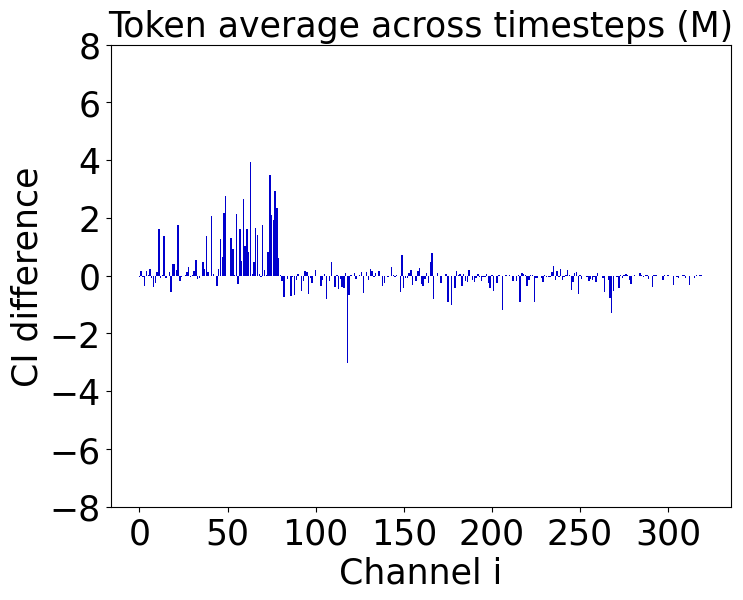

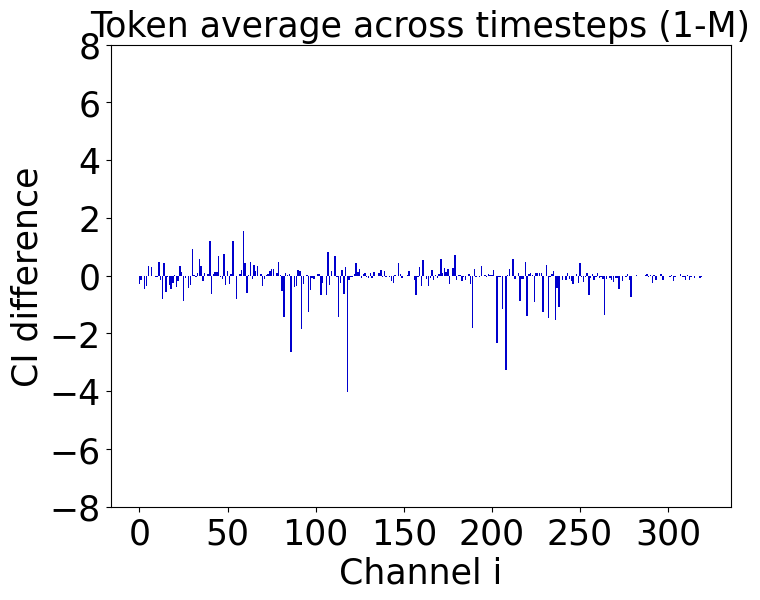

In [37]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
# in mask
mask=condition_mask[0,0]
flat_mask=mask.flatten().cpu()
mask_indices_true=torch.where(flat_mask==True)[0]
mask_indices_false=torch.where(flat_mask==False)[0]
layer=1
show_k=3
indicator="c"

m1=[]
m2=[]
class avg_metrics:
    def __init__(self):
        self.cur_mean=0
        self.cur_sample=0
    def update(self,val):
        self.cur_sample += 1
        self.cur_mean = val/self.cur_sample + self.cur_mean*((self.cur_sample-1)/self.cur_sample)
        return self.cur_mean
metric = avg_metrics()
for step in range(50):
    for token_idx in range(1,10):

        token=pipe.tokenizer.decode(text_input_ids[0][token_idx])
        token_feature_k=editor.cross_token_k_dict[indicator][step][layer]
        token_feature_q_1 = n_editor.cross_token_q_dict[indicator][step][layer]
        token_feature_q_2 = editor.cross_token_q_dict[indicator][step][layer]
        sim_matrix_1=token_feature_q_1*token_feature_k[:,token_idx:token_idx+1,:]
        sim_matrix_2=token_feature_q_2*token_feature_k[:,token_idx:token_idx+1,:]
        sim_diff = sim_matrix_2-sim_matrix_1
        sim_diff=sim_diff.permute(1,0,2)
        sim_shape=sim_diff.shape
        sim_diff=sim_diff.reshape(sim_shape[0],-1)
        channel_wise_sum=torch.mean(sim_diff[mask_indices_true],dim=0)
        metric.update(channel_wise_sum)


index = np.arange(len(data))
# 畫出條狀圖
plt.figure(figsize=(8, 6))

data = metric.cur_mean
m1.append(data)
plt.bar(index, data, color='mediumblue')
plt.xlabel('Channel i',fontsize=25)
plt.ylabel("CI difference",fontsize=25)
plt.title(f'Token average across timesteps (M)',fontsize=25)
plt.xticks(fontsize=25)                         
plt.yticks(fontsize=25)
plt.ylim(-8,8)

plt.figure(figsize=(8, 6))
channel_wise_sum=torch.mean(sim_diff[mask_indices_false],dim=0)
data = channel_wise_sum
m2.append(data)
plt.bar(index, data, color='mediumblue')
plt.xlabel('Channel i',fontsize=25)
plt.ylabel("CI difference",fontsize=25)
plt.title(f'Token average across timesteps (1-M)',fontsize=25)
plt.xticks(fontsize=25)                         
plt.yticks(fontsize=25)
plt.ylim(-8,8)